In [2]:
%tensorflow_version 2.x
import pathlib
import typing
import tensorflow as tf
import math
import PIL
import numpy as np
import matplotlib.pyplot as plt

tf.config.list_physical_devices('GPU')

TensorFlow 2.x selected.


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [0]:
from google.colab import drive
drive.mount('/content/drive')

In [0]:
LABELS = [
    "empty",
    "black_knight",
    "black_bishop",
    "black_king",
    "black_pawn",
    "black_queen",
    "black_rook",
    "white_knight",
    "white_bishop",
    "white_king",
    "white_pawn",
    "white_queen",
    "white_rook",
]
labels = tf.constant(LABELS)

IMAGE_SIZE = 300, 300

In [0]:
# Create dataset
data_path = pathlib.Path("/content/drive/My Drive") / "pieces"
train_path = str(data_path / "train" / "*" / "*.jpg")
validation_path = str(data_path / "val" / "*" / "*.jpg")
NUM_TRAIN = len(list((data_path / "train").glob("*/*.jpg")))
NUM_VAL = len(list((data_path / "val").glob("*/*.jpg")))
train = tf.data.Dataset.list_files(train_path)
val = tf.data.Dataset.list_files(val_path)

def get_data_from_path(path: tf.Tensor) -> typing.Tuple[tf.Tensor, tf.Tensor]:
    label = tf.strings.split(path, '/')[-2]
    label = tf.cast(labels == label, tf.int8)
    img = tf.io.read_file(path)
    img = tf.image.decode_jpeg(img)
    img = tf.image.resize(img, IMAGE_SIZE)
    img = tf.keras.applications.inception_v3.preprocess_input(img)
    return img, label

TRAIN_BATCH_SIZE = 64
VAL_BATCH_SIZE = 16
train = train.shuffle(10000).map(get_data_from_path).batch(TRAIN_BATCH_SIZE, drop_remainder=True).repeat()
val = val.shuffle(50).map(get_data_from_path).batch(VAL_BATCH_SIZE, drop_remainder=True).repeat()

In [5]:
inception_model = tf.keras.applications.InceptionV3(
    input_shape=IMAGE_SIZE + (3,),
    include_top=False,
    weights="imagenet"
)

87916544/87910968 [==============================] - 2s 0us/step


In [6]:
# Freeze the pre-trained model weights
inception_model.trainable = False

model = tf.keras.Sequential([
    inception_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dropout(.5),
    tf.keras.layers.Dense(64, activation="relu"),
    tf.keras.layers.Dropout(.2),
    tf.keras.layers.Dense(32, activation="relu"),
    tf.keras.layers.Dense(len(LABELS), activation="softmax")
])

# Compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(lr=.001), 
              loss="categorical_crossentropy",
              metrics=["categorical_accuracy"]
)
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Model)         (None, 8, 8, 2048)        21802784  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dropout (Dropout)            (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 64)                131136    
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_2 (Dense)              (None, 13)                4

In [7]:
STEPS_PER_EPOCH = NUM_TRAIN // TRAIN_BATCH_SIZE
VALIDATION_STEPS = NUM_VAL // VAL_BATCH_SIZE
history = model.fit(
    train,
    epochs=5,
    steps_per_epoch=STEPS_PER_EPOCH,
    validation_data=val,
    validation_steps=VALIDATION_STEPS)

Train for 101 steps, validate for 4 steps
Epoch 1/5
101/101 [==============================] - 1752s 17s/step - loss: 2.0595 - categorical_accuracy: 0.2859 - val_loss: 1.2357 - val_categorical_accuracy: 0.5938
Epoch 2/5
101/101 [==============================] - 21s 212ms/step - loss: 1.1135 - categorical_accuracy: 0.6219 - val_loss: 1.3254 - val_categorical_accuracy: 0.6406
Epoch 3/5
101/101 [==============================] - 22s 213ms/step - loss: 0.7871 - categorical_accuracy: 0.7347 - val_loss: 1.1696 - val_categorical_accuracy: 0.5781
Epoch 4/5
101/101 [==============================] - 22s 214ms/step - loss: 0.6403 - categorical_accuracy: 0.7839 - val_loss: 1.6924 - val_categorical_accuracy: 0.7031
Epoch 5/5
101/101 [==============================] - 21s 213ms/step - loss: 0.5720 - categorical_accuracy: 0.8035 - val_loss: 1.5594 - val_categorical_accuracy: 0.7031


In [8]:
inception_model.trainable = True
# Compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(lr=.0001), 
              loss="categorical_crossentropy",
              metrics=["categorical_accuracy"])
model.summary()
history = model.fit(
    train,
    epochs=2,
    steps_per_epoch=STEPS_PER_EPOCH,
    validation_data=val,
    validation_steps=VALIDATION_STEPS)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Model)         (None, 8, 8, 2048)        21802784  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dropout (Dropout)            (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 64)                131136    
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_2 (Dense)              (None, 13)                4

Number of samples: 64
Categorical accuracy: 1.0


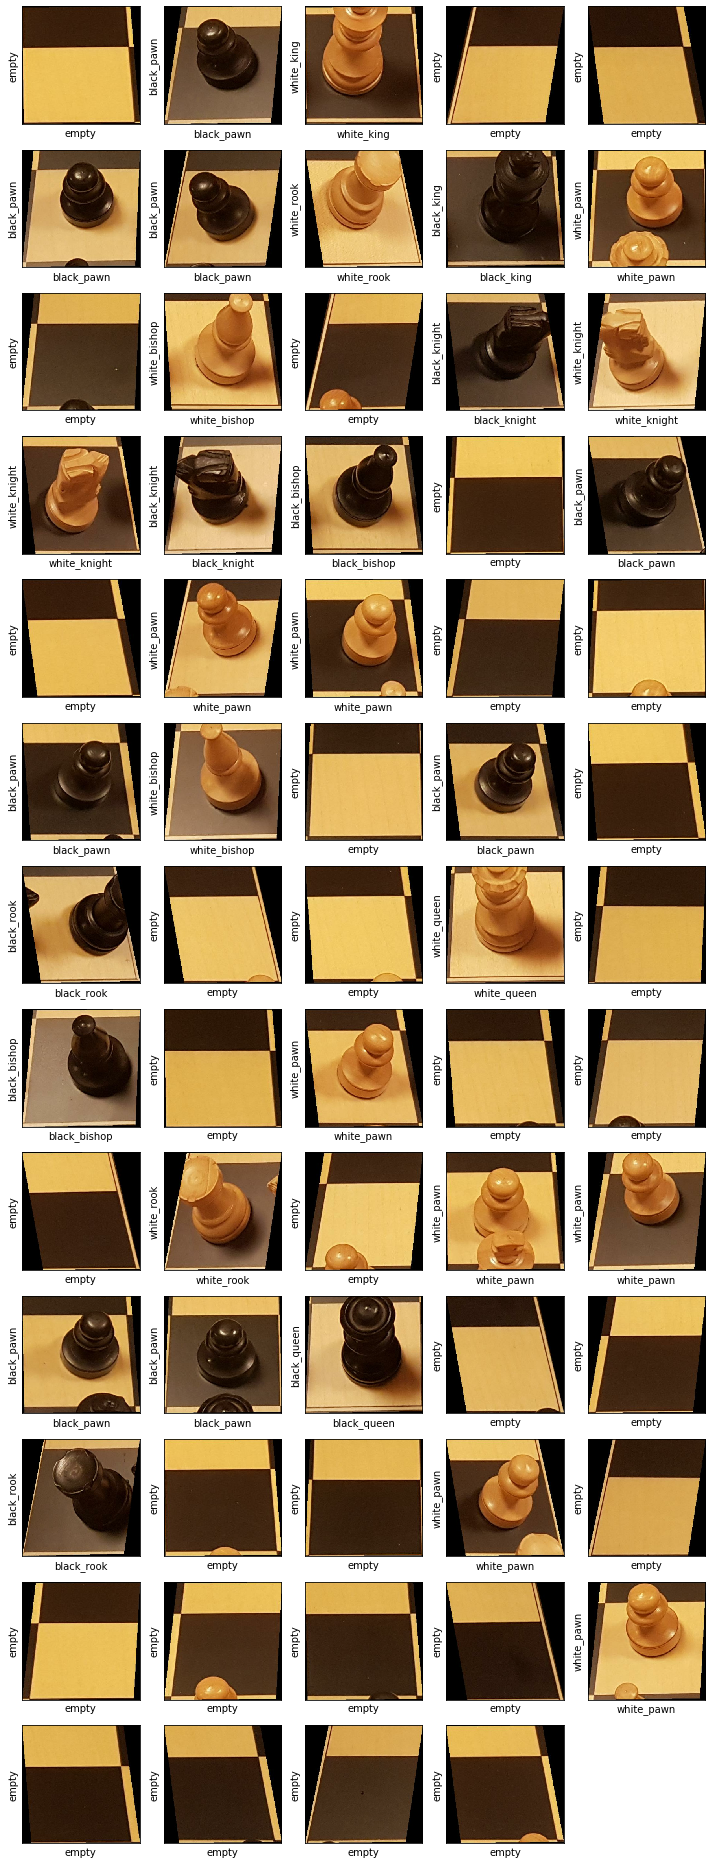

In [12]:
NUM_SAMPLES = 64

x, y = next(iter(test.unbatch().batch(NUM_SAMPLES).take(1)))
y_hat = model.predict(x)
print("Number of samples:", y.shape[0])

accuracy = tf.keras.metrics.categorical_accuracy(y, y_hat)
print("Categorical accuracy:", tf.reduce_mean(accuracy).numpy())

def transform(results):
  return tf.gather(labels, tf.argmax(results, axis=-1))
y = transform(y)
y_hat = transform(y_hat)


columns = 5
rows = math.ceil(NUM_SAMPLES / columns)
fig = plt.figure(figsize=(2 * columns, 2 * rows))
imgs = tf.cast((x + 1.) * 127.5, tf.uint8)
for i, (img, actual, predicted) in enumerate(zip(imgs, y, y_hat), 1):
    fig.add_subplot(rows, columns, i)
    plt.imshow(img)
    plt.xticks([])
    plt.yticks([])
    plt.xlabel(predicted.numpy().decode("utf-8"))
    plt.ylabel(actual.numpy().decode("utf-8"))
plt.tight_layout()
plt.show()

In [0]:
model.save("/content/drive/My Drive/model.h5")